In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetMobile,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = NASNetMobile(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 69s 22ms/step - loss: 0.3716 - acc: 0.8585 - val_loss: 2.0117 - val_acc: 0.4943
Epoch 2/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.2424 - acc: 0.9173 - val_loss: 0.8508 - val_acc: 0.6836
Epoch 3/100
3144/3144 [==============================] - 50s 16ms/step - loss: 0.1845 - acc: 0.9307 - val_loss: 1.9019 - val_acc: 0.4587
Epoch 4/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.1496 - acc: 0.9450 - val_loss: 2.4732 - val_acc: 0.5006
Epoch 5/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.1321 - acc: 0.9545 - val_loss: 0.4816 - val_acc: 0.8437
Epoch 6/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.1093 - acc: 0.9602 - val_loss: 2.4903 - val_acc: 0.4841
Epoch 7/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.0806 - acc: 0.9707 - val_loss: 0.9344 - val_acc: 0

3144/3144 [==============================] - 51s 16ms/step - loss: 0.0167 - acc: 0.9936 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 61/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.0059 - acc: 0.9984 - val_loss: 5.8273 - val_acc: 0.6290
Epoch 62/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0166 - acc: 0.9959 - val_loss: 7.4439 - val_acc: 0.5324
Epoch 63/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.0062 - acc: 0.9975 - val_loss: 7.8482 - val_acc: 0.5095
Epoch 64/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.0023 - acc: 0.9997 - val_loss: 6.6058 - val_acc: 0.5769
Epoch 65/100
3144/3144 [==============================] - 52s 16ms/step - loss: 3.9461e-04 - acc: 1.0000 - val_loss: 6.4695 - val_acc: 0.5896
Epoch 66/100
3144/3144 [==============================] - 51s 16ms/step - loss: 5.1589e-04 - acc: 1.0000 - val_loss: 6.3151 - val_acc: 0.5985
Epoch 67/100
3144/3144 [===============

3145/3145 [==============================] - 51s 16ms/step - loss: 0.0305 - acc: 0.9911 - val_loss: 3.9849 - val_acc: 0.5000
Epoch 19/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0481 - acc: 0.9854 - val_loss: 4.1785 - val_acc: 0.4542
Epoch 20/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0425 - acc: 0.9828 - val_loss: 4.9586 - val_acc: 0.4109
Epoch 21/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0163 - acc: 0.9940 - val_loss: 2.1198 - val_acc: 0.4911
Epoch 22/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0184 - acc: 0.9936 - val_loss: 3.6592 - val_acc: 0.4211
Epoch 23/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0482 - acc: 0.9844 - val_loss: 4.2174 - val_acc: 0.4453
Epoch 24/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0277 - acc: 0.9911 - val_loss: 4.0744 - val_acc: 0.3028
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 51s 16ms/step - loss: 0.0054 - acc: 0.9981 - val_loss: 7.8461 - val_acc: 0.5013
Epoch 78/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0016 - acc: 0.9994 - val_loss: 7.4782 - val_acc: 0.4987
Epoch 79/100
3145/3145 [==============================] - 51s 16ms/step - loss: 3.8995e-04 - acc: 1.0000 - val_loss: 7.4595 - val_acc: 0.5000
Epoch 80/100
3145/3145 [==============================] - 50s 16ms/step - loss: 9.4312e-04 - acc: 0.9997 - val_loss: 7.9189 - val_acc: 0.4606
Epoch 81/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0142 - acc: 0.9965 - val_loss: 6.4585 - val_acc: 0.5814
Epoch 82/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0198 - acc: 0.9952 - val_loss: 7.8897 - val_acc: 0.4593
Epoch 83/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0169 - acc: 0.9940 - val_loss: 7.1729 - val_acc: 0.5165
Epoch 84/100
3145/3145 [===============

3145/3145 [==============================] - 50s 16ms/step - loss: 0.0496 - acc: 0.9863 - val_loss: 5.4749 - val_acc: 0.5000
Epoch 36/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0621 - acc: 0.9793 - val_loss: 7.8812 - val_acc: 0.4949
Epoch 37/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0264 - acc: 0.9908 - val_loss: 8.0993 - val_acc: 0.4949
Epoch 38/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0461 - acc: 0.9863 - val_loss: 7.3598 - val_acc: 0.5038
Epoch 39/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0323 - acc: 0.9892 - val_loss: 6.1926 - val_acc: 0.4975
Epoch 40/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0402 - acc: 0.9870 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 41/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.0238 - acc: 0.9930 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 50s 16ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 7.6414 - val_acc: 0.4478
Epoch 95/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 7.7662 - val_acc: 0.3842
Epoch 96/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0118 - acc: 0.9962 - val_loss: 7.9111 - val_acc: 0.5025
Epoch 97/100
3145/3145 [==============================] - 49s 16ms/step - loss: 0.0111 - acc: 0.9959 - val_loss: 6.7995 - val_acc: 0.4962
Epoch 98/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0492 - acc: 0.9831 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 99/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0179 - acc: 0.9933 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 100/100
786/786 [==============================] - 3s 4ms/step
[2] Test acurracy: 0.5051 (5010.9404 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [======

3145/3145 [==============================] - 50s 16ms/step - loss: 0.0187 - acc: 0.9962 - val_loss: 2.1246 - val_acc: 0.6323
Epoch 53/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0368 - acc: 0.9873 - val_loss: 6.7728 - val_acc: 0.5051
Epoch 54/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0186 - acc: 0.9943 - val_loss: 6.4590 - val_acc: 0.4949
Epoch 55/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0184 - acc: 0.9949 - val_loss: 8.3265 - val_acc: 0.4606
Epoch 56/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0365 - acc: 0.9889 - val_loss: 4.3382 - val_acc: 0.6170
Epoch 57/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0059 - acc: 0.9990 - val_loss: 4.6707 - val_acc: 0.5827
Epoch 58/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0241 - acc: 0.9936 - val_loss: 3.8567 - val_acc: 0.7506
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 50s 16ms/step - loss: 0.1406 - acc: 0.9545 - val_loss: 0.8350 - val_acc: 0.4949
Epoch 11/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.1101 - acc: 0.9688 - val_loss: 0.8320 - val_acc: 0.4949
Epoch 12/100
3145/3145 [==============================] - 51s 16ms/step - loss: 0.1019 - acc: 0.9663 - val_loss: 0.8753 - val_acc: 0.4949
Epoch 13/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0832 - acc: 0.9720 - val_loss: 0.8524 - val_acc: 0.4949
Epoch 14/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0817 - acc: 0.9762 - val_loss: 0.8432 - val_acc: 0.4949
Epoch 15/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0604 - acc: 0.9819 - val_loss: 0.8439 - val_acc: 0.4949
Epoch 16/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0555 - acc: 0.9793 - val_loss: 0.8467 - val_acc: 0.4949
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 50s 16ms/step - loss: 0.0604 - acc: 0.9784 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 70/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0453 - acc: 0.9857 - val_loss: 8.1301 - val_acc: 0.4949
Epoch 71/100
3145/3145 [==============================] - 49s 16ms/step - loss: 0.0133 - acc: 0.9955 - val_loss: 8.0825 - val_acc: 0.4949
Epoch 72/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0123 - acc: 0.9965 - val_loss: 8.0120 - val_acc: 0.4949
Epoch 73/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 7.8579 - val_acc: 0.4975
Epoch 74/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 7.6835 - val_acc: 0.5038
Epoch 75/100
3145/3145 [==============================] - 50s 16ms/step - loss: 0.0128 - acc: 0.9968 - val_loss: 7.4924 - val_acc: 0.5064
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.5256


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

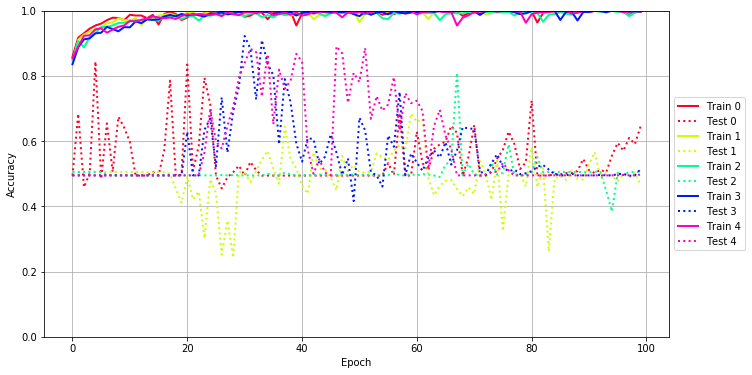

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

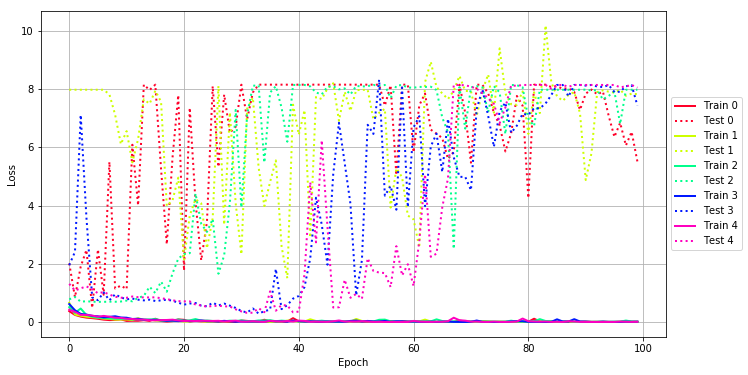

In [12]:
plot_loss(history)

Plotting the confusion matrix


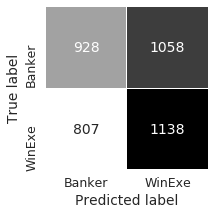

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


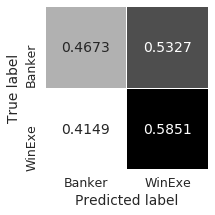

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'loss': [0.37158018547766686, 0.24242644173119207, 0.18452272323403346, 0.1496114866954983, 0.13207091015713815, 0.10930582842109464, 0.08062319987413234, 0.06457247325330594, 0.06981808485216805, 0.08932417757813901, 0.03574943994752513, 0.042511155711529594, 0.04145622952028388, 0.06126984927457291, 0.03641054234420051, 0.11173956818954484, 0.03340026271116562, 0.014543722309548356, 0.029073053511196118, 0.08895474405717531, 0.07444941854748979, 0.018812464965441034, 0.03595290065247746, 0.021838686007514013, 0.01771802425290619, 0.019020245174709093, 0.008046377777627315, 0.005362988302966108, 0.00280588076790364, 0.0026525290443231092, 0.05123232701450732, 0.03695993580465601, 0.014215530391158086, 0.01851127925417777, 0.0769967044153874, 0.020870626208836892, 0.005615391203063972, 0.0025737719901297693, 0.014777449986891632, 0.13175261641542116, 0.024749054364343447, 0.012190147300823129, 0.024650592984170737, 0.012106006894614335, 0.009480035910916066, 0.006639075091704975, 0.00

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

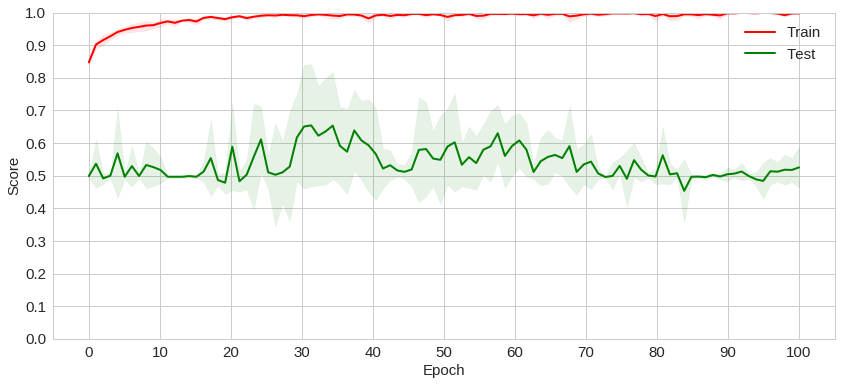

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

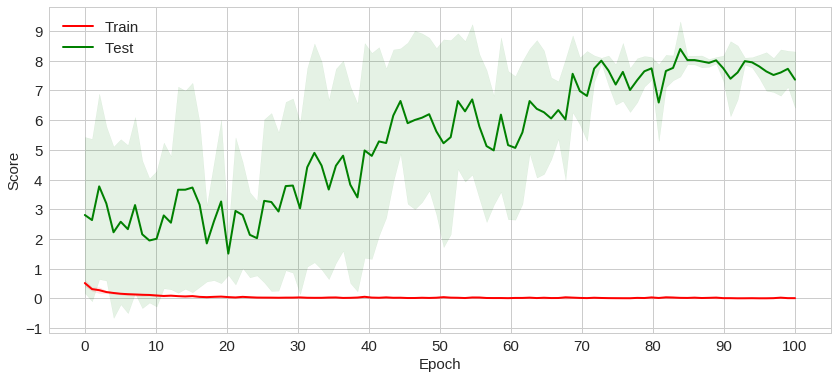

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'loss': [0.37158018547766686, 0.24242644173119207, 0.18452272323403346, 0.1496114866954983, 0.13207091015713815, 0.10930582842109464, 0.08062319987413234, 0.06457247325330594, 0.06981808485216805, 0.08932417757813901, 0.03574943994752513, 0.042511155711529594, 0.04145622952028388, 0.06126984927457291, 0.03641054234420051, 0.11173956818954484, 0.03340026271116562, 0.014543722309548356, 0.029073053511196118, 0.08895474405717531, 0.07444941854748979, 0.018812464965441034, 0.03595290065247746, 0.021838686007514013, 0.01771802425290619, 0.019020245174709093, 0.008046377777627315, 0.005362988302966108, 0.00280588076790364, 0.0026525290443231092, 0.05123232701450732, 0.03695993580465601, 0.014215530391158086, 0.01851127925417777, 0.0769967044153874, 0.020870626208836892, 0.005615391203063972, 0.0025737719901297693, 0.014777449986891632, 0.13175261641542116, 0.024749054364343447, 0.012190147300823129, 0.024650592984170737, 0.012106006894614335, 0.009480035910916066, 0.006639075091704975, 0.003137390829481892, 0.005892797918765421, 0.016847838784740412, 0.019418073526012495, 0.015631069843441536, 0.013836904601744937, 0.002999076929014156, 0.00868036265061539, 0.03577701962667307, 0.019907658794464107, 0.03291802474181464, 0.008427322618014585, 0.02622391032078718, 0.016695613613451118, 0.0059223022380353214, 0.016638719709293856, 0.006198269195945604, 0.002256933730909125, 0.00039460859704860745, 0.0005158853042886422, 0.0034188670752644534, 0.007478811690629202, 0.04735118514009065, 0.020541545339864763, 0.003671632187241634, 0.027144748140079812, 0.011981155267438147, 0.003488731922453824, 0.00031260562566741694, 0.001957735618033145, 0.006630089931303893, 0.010678321306947553, 0.0025905526860903103, 0.0017808755996962188, 0.007784738115576307, 0.11230587241246955, 0.01770575000211637, 0.007329609844856273, 0.005101686740821671, 0.005042123752903121, 0.0047361688963763705, 0.0015617318177269445, 0.002696845434629329, 0.00961006875130466, 0.014438724205722564, 0.00323824720610232, 0.00047071773944495855, 0.0014466887252815156, 0.0022569901913150046, 0.0009717742661251732, 0.00780296306672551, 0.03154473194580169, 0.010353968074766247, 0.007868854123698745], 'val_loss': [2.0117107145427613, 0.8507843212505005, 1.9018783257301457, 2.473241559649892, 0.48159792242048655, 2.49031295035664, 0.934442673129381, 5.4994849803487105, 1.1503013714750356, 1.2490887381680773, 1.129862732986483, 6.087328139943859, 4.006073375513528, 8.151209750429299, 7.966885858751471, 8.151209672948458, 5.254461873100922, 2.6675788504953153, 5.649434970897737, 7.790511792163533, 1.7683909381662875, 7.355411254163013, 4.1368777653465125, 2.115248314080123, 3.4415638755706377, 8.099898690719922, 5.325558840849802, 7.81064990184677, 6.501708214126521, 6.70291127349705, 8.151209672948458, 6.963741812892874, 7.8845197999947025, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.151209672948458, 7.430906291383649, 8.130729237081438, 5.046155335185185, 8.151209672948458, 8.151209672948458, 5.827284992574282, 7.4438881630212865, 7.848225757915155, 6.605779698267674, 6.469481219330464, 6.315117670741439, 5.596739831085884, 5.849441317779911, 8.150075201158147, 7.1853978429392, 5.470891188787536, 8.151209672948458, 8.143767416704414, 7.854541975327944, 7.180478415162015, 6.755249826623347, 5.856920048878487, 6.476651362664267, 7.7638515855033035, 7.428292405347812, 4.257558274451001, 8.151209672948458, 8.151209672948458, 8.151209672948458, 8.069289054016297, 8.0897683653474, 8.014629964301365, 8.028754623751174, 7.8991874471552945, 7.285555836509113, 7.842527943766253, 7.983495372617345, 7.818697571148563, 7.911669128125928, 7.081872070380966, 6.355224599453515, 6.841203322404525, 6.062753454854255, 6.531186416461174, 5.513796415837929], 'val_acc': [0.49428208386277, 0.6836086404066074, 0.45870394022067895, 0.5006353240152478, 0.843710292249047, 0.48411689977027866, 0.6543837354780001, 0.5057179161372299, 0.6747141035872463, 0.6416772554002541, 0.5972045748630654, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.5057179161372299, 0.49428208386277, 0.5730622617534943, 0.7852604831491977, 0.49428208386277, 0.49682337992376113, 0.8348157561870512, 0.5095298602287166, 0.584498093270589, 0.7941550201200318, 0.7128335455624242, 0.49428208386277, 0.45489199484167137, 0.4891994917407878, 0.5044472681067345, 0.524777637124819, 0.49428208386277, 0.5362134693992789, 0.5108005082592122, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.5324015247776366, 0.49555273189326554, 0.6861499366190715, 0.49428208386277, 0.49428208386277, 0.6289707761556099, 0.5324015247776366, 0.5095298607588723, 0.5768742069052922, 0.5895806872102478, 0.5984752234237167, 0.6467598476737094, 0.6251588320641233, 0.4942820843929257, 0.5514612452350699, 0.6493011446435388, 0.49428208386277, 0.49428208386277, 0.5069885641677255, 0.5463786531130876, 0.5730622617534943, 0.6289707750952986, 0.590851334180432, 0.5146124523506989, 0.5349428213687833, 0.7242693779126207, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.4993646759847522, 0.49809402795425667, 0.5019059720457433, 0.5019059720457433, 0.5082592121982211, 0.5451080043252269, 0.5108005082592122, 0.5019059720457433, 0.5120711562897078, 0.5044472681067345, 0.5552731898567123, 0.5946632788020744, 0.5705209662226588, 0.6099110546378653, 0.5908513347105877, 0.6454891996432138], 'acc': [0.8584605597964376, 0.9173027989821882, 0.9306615776081425, 0.9449745547073791, 0.9545165394402035, 0.9602417302798982, 0.9707379134860051, 0.9783715012722646, 0.9770992366412213, 0.9707379134860051, 0.9872773536895675, 0.9850508905852418, 0.9850508905852418, 0.9770992366412213, 0.9869592875318066, 0.9573791348600509, 0.9901399491094147, 0.9952290076335878, 0.9901399491094147, 0.9710559796437659, 0.9790076335877863, 0.9920483460559797, 0.9869592875318066, 0.9917302798982188, 0.9930025445292621, 0.9942748091603053, 0.9977735368956743, 0.9980916030534351, 0.9993638676844784, 0.9993638676844784, 0.9812340966921119, 0.9847328244274809, 0.9955470737913485, 0.9939567430025446, 0.9736005089058524, 0.9930025445292621, 0.9980916030534351, 0.9993638676844784, 0.9980916030534351, 0.9545165394402035, 0.9914122137404581, 0.9968193384223919, 0.9910941475826972, 0.9952290076335878, 0.9971374045801527, 0.9980916030534351, 0.9987277353689568, 0.9996819338422391, 0.9939567430025446, 0.9917302798982188, 0.9955470737913485, 0.9945928753180662, 0.9993638676844784, 0.9971374045801527, 0.9872773536895675, 0.9926844783715013, 0.9891857506361323, 0.9968193384223919, 0.9910941475826972, 0.9936386768447837, 0.9984096692111959, 0.9958651399491094, 0.9974554707379135, 0.9996819338422391, 1.0, 1.0, 0.9977735368956743, 0.9971374045801527, 0.9840966921119593, 0.9920483460559797, 0.9993638676844784, 0.9891857506361323, 0.9968193384223919, 0.9993638676844784, 1.0, 0.9993638676844784, 0.9974554707379135, 0.9977735368956743, 0.9990458015267175, 0.9990458015267175, 0.9977735368956743, 0.9637404580152672, 0.9923664122137404, 0.9974554707379135, 0.9980916030534351, 0.9980916030534351, 0.9984096692111959, 0.9996819338422391, 0.9990458015267175, 0.9971374045801527, 0.9952290076335878, 0.9993638676844784, 1.0, 0.9990458015267175, 0.9990458015267175, 0.9996819338422391, 0.9971374045801527, 0.9901399491094147, 0.9984096692111959, 0.9968193384223919]},
{'loss': [0.6588750046321054, 0.25575058353629515, 0.21292489343493087, 0.18164065783467315, 0.16291445371219576, 0.1468882633127355, 0.11421101905393677, 0.10750877950547799, 0.07919949758412917, 0.08326663908760384, 0.08436700682531871, 0.06801304164296683, 0.1294675110408441, 0.07295836232993486, 0.07812773550021061, 0.04780392389987345, 0.03971937240378277, 0.03054039293991932, 0.04805459004896434, 0.042518053037397245, 0.01627028711689473, 0.01843436167094951, 0.04822620120616141, 0.02767942565047613, 0.006305388847753903, 0.0142673602925883, 0.02479040284962386, 0.023733883685416086, 0.021943253405475087, 0.03510711758874286, 0.027637406648395788, 0.020782838417150507, 0.010914633158370053, 0.004036511910466858, 0.0010966431968238365, 0.0007210722134173929, 0.0008413754441701731, 0.00510556477786955, 0.0488042448230335, 0.03086889647761736, 0.014183008323150293, 0.013772121267704166, 0.09330568749617507, 0.03307570386707593, 0.032862316326316, 0.007666080345515167, 0.010041246161054352, 0.018845187362234606, 0.011831272853018689, 0.010560093903492112, 0.10433536364514802, 0.035322598254216304, 0.025654633949986037, 0.012068558141695771, 0.016236722267851743, 0.007159703175373446, 0.001800202246897318, 0.0005060584360161222, 0.00027793556785543, 0.0007242309937164132, 0.0009812638603316677, 0.020297789000155088, 0.08219116913163606, 0.01525504743067373, 0.004222821943748399, 0.0009826166792696828, 0.00037650791821635434, 0.0006847518647240626, 0.0007629412748394897, 0.0002631555906224608, 0.00022146657697248162, 0.003027484753084538, 0.03357791830054275, 0.023141218373765825, 0.010096387552920676, 0.014249889151136775, 0.005395241490979727, 0.00159679142160812, 0.00038994520524075657, 0.0009431154240714303, 0.014173466959153986, 0.019825373937915166, 0.016860497411635124, 0.03250958045810574, 0.035081515253028446, 0.005537635199181492, 0.016216082195788385, 0.018836850040856546, 0.004638489783530172, 0.0008129920690696931, 0.001867931997723691, 0.0036330114152485693, 0.00862210756398194, 0.012827454897284412, 0.0023572974454645593, 0.00025724027150513055, 0.004134463089015433, 0.019465369446865895, 0.004013292414458918, 0.005596448683981497], 'val_loss': [7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.816358603320989, 7.115377847427554, 6.107161692194357, 6.5549689002012785, 5.4799260360594015, 6.281932418696753, 7.648002211450014, 7.495057900746663, 7.940670453953578, 7.565395829786781, 3.984884432557278, 4.178541640288957, 4.958563548007994, 2.119812158531208, 3.6592118376083955, 4.2173581717881845, 4.074385108535223, 2.5307252777138434, 3.5629151813856517, 8.106000445271267, 3.340569601714156, 7.195306331450096, 4.081921808819734, 2.3252711520546874, 7.325361614008896, 7.706973087964067, 5.3107477578194695, 3.979572768126432, 4.808840655188524, 5.551172023511115, 2.5989713474691065, 1.5024605573891987, 7.463749169404014, 6.432099999968939, 7.276975824632718, 2.9020556321346294, 7.729379366743808, 7.657766264766744, 8.018818289302194, 8.199095762412966, 6.910398238525595, 7.907165666725158, 7.249700205212188, 7.963557490865694, 7.972893663945093, 7.97702183614251, 6.967105314049869, 7.187632758506372, 7.320046256411567, 3.930433563300368, 5.278926229355596, 4.972865815684389, 3.6568066873623213, 3.5246696921098626, 2.5570233850988724, 8.23647154226872, 8.938743700507944, 8.065633874509777, 7.849565231769747, 7.65625500254352, 7.940514945498556, 8.452470374168026, 7.936647231948891, 7.925409164137513, 7.077869337158341, 7.950217972312871, 8.501353358494416, 7.188930956858451, 9.399335992245273, 7.846140000732194, 7.478232520833877, 7.459468976231932, 7.9188671888589255, 6.458501680960297, 7.889672810794743, 7.172882288846047, 10.18445146720828, 8.239149406969396, 7.74884470030855, 7.595039516914892, 7.798094033642941, 7.896514827930593, 7.168682088378731, 4.87435180904301, 5.797188250959374, 7.900289784330145, 7.956531439921475, 7.909784279934323, 7.878455953212791, 7.976440561435021, 7.770138342511714, 7.842979483322107, 7.824093730395077], 'val_acc': [0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5038167938931297, 0.5050890585241731, 0.5050890585241731, 0.5000000000094791, 0.4541984732824427, 0.4109414758459302, 0.49109414788602873, 0.4211195940886442, 0.4452926209788893, 0.3027989827949582, 0.4834605598343541, 0.44147582712367595, 0.2519083975532279, 0.35623409670159106, 0.24300254468092786, 0.5050890585241731, 0.5025445295654181, 0.474554707388614, 0.5076335877862596, 0.5432569974933872, 0.5699745548590449, 0.516539440431061, 0.46946564908246047, 0.6450381679389313, 0.5458015267554737, 0.5165394402130414, 0.4631043258514113, 0.43893129816492094, 0.5648854962211225, 0.5152671755819982, 0.5127226463199117, 0.4885496183300898, 0.44910941487201905, 0.5547073792486094, 0.5076335877957386, 0.5267175572708667, 0.5050890585336522, 0.5038167938931297, 0.5050890585241731, 0.562340966959036, 0.5508905853554796, 0.5419847329381768, 0.5712468190350909, 0.5877862596178176, 0.5725190845761287, 0.6844783719562696, 0.6590330793354044, 0.6679389319043729, 0.4872773536895674, 0.4338422392047089, 0.46310432571870375, 0.47837150142393037, 0.4809160311410142, 0.4529262088788981, 0.43129771015116275, 0.4580152671755725, 0.4376590342922065, 0.5407124682313007, 0.49872773536895676, 0.419847328263233, 0.5407124682123424, 0.32442748167435936, 0.5012722646310432, 0.49872773548270605, 0.5000000001137493, 0.46055979645661727, 0.5814249365384342, 0.4592875318160949, 0.5165394402414788, 0.2620865141465767, 0.4860050890585242, 0.49363867684478374, 0.4809160311410142, 0.510178117048346, 0.4847328244274809, 0.48218829518435263, 0.5279898229446119, 0.5661577608521658, 0.4872773536895674, 0.5025445292620865, 0.4910941475826972, 0.4770992366412214, 0.49872773536895676, 0.48854961832061067, 0.5025445292620865, 0.46564885496183206], 'acc': [0.8406995230524642, 0.9103338634645617, 0.9268680445151033, 0.9351351351540873, 0.9440381558028617, 0.9488076311605723, 0.9608903022562946, 0.9640699523052464, 0.9761526232114467, 0.9704292527821939, 0.9707472178060413, 0.9767885533159981, 0.9548489666136725, 0.9771065183208932, 0.9745627980922098, 0.9853736089030206, 0.9872813990461049, 0.9910969795217953, 0.9853736089219729, 0.9828298887122416, 0.9939586645468999, 0.9936406995230525, 0.9844197138504307, 0.9910969793322735, 0.9987281399046105, 0.9961844197138314, 0.9910969793322735, 0.9930047694753578, 0.9926868046410322, 0.9895071542130366, 0.9914149443561209, 0.9958664546899841, 0.9965023847376788, 0.9987281399046105, 1.0, 1.0, 0.9996820349761526, 0.9980922098758679, 0.9841017488076311, 0.9904610492845787, 0.9952305246422893, 0.9955484896850889, 0.9739268680824195, 0.9866454689984102, 0.9879173290937997, 0.9977742448330683, 0.997456279809221, 0.9936406995230525, 0.9965023847376788, 0.9980922098948202, 0.9650238475663104, 0.9891891892081414, 0.9914149443561209, 0.9961844199033534, 0.992368839427663, 0.9977742448330683, 1.0, 1.0, 1.0, 0.9996820349761526, 1.0, 0.9949125596373941, 0.9739268680445151, 0.9952305246422893, 0.9993640699523052, 1.0, 1.0, 0.9996820349761526, 1.0, 1.0, 1.0, 0.9990461049284579, 0.9875993640699523, 0.993322734499205, 0.9977742448330683, 0.9942766295707473, 0.9980922098569157, 0.9993640699523052, 1.0, 0.9996820349761526, 0.9965023847376788, 0.9952305246422893, 0.9939586645468999, 0.9936406995420046, 0.9885532591414944, 0.9990461049284579, 0.9930047694943099, 0.993322734499205, 0.9990461049284579, 1.0, 0.9993640699523052, 0.9984101748807631, 0.9977742448330683, 0.9971383147853736, 0.9996820349761526, 1.0, 0.9977742448330683, 0.9936406995230525, 0.9990461049284579, 0.9984101748807631]},
{'loss': [0.5095610515491382, 0.31261349932567495, 0.46163985633035154, 0.2371363565823232, 0.18307923001780607, 0.14578703165599197, 0.1433915388982133, 0.12245431095598612, 0.11290471240143708, 0.10877041258983942, 0.10788372857866302, 0.08878219704275479, 0.0910556619895092, 0.07998178959461388, 0.0794024947858956, 0.0988778319654006, 0.059410803882325204, 0.05539448509771608, 0.055702319070815284, 0.08647192410194865, 0.04543582249095216, 0.055325680990097825, 0.09998711112572771, 0.04655191686081393, 0.04946993086694344, 0.03487983387236044, 0.03134527892290373, 0.021987391864238322, 0.04490804616213792, 0.03317737532864711, 0.05348800989741456, 0.026337757974193802, 0.025271903961269104, 0.05207691848217339, 0.04963190013066005, 0.0620632223779001, 0.026387089968693038, 0.046082666714413655, 0.03228389379140493, 0.0402299372535954, 0.023822624528327504, 0.025300144061404732, 0.020414509388932068, 0.025789242464880974, 0.04496874277182338, 0.023596750677856417, 0.01479560447482367, 0.01565041108610662, 0.0228338265980317, 0.02656514711073927, 0.019860834812016975, 0.027056613631083058, 0.02251281180606051, 0.016282703081406474, 0.07569547845154337, 0.08174115754693558, 0.02176047081871044, 0.022413483128508344, 0.009545315329477026, 0.009128072721397264, 0.01497687956061507, 0.017299183999485854, 0.02139900794386196, 0.018880647295028776, 0.09039595877730978, 0.033600612848831285, 0.020281459045535716, 0.017244938305995185, 0.018668469410265287, 0.01011931183610988, 0.02450177290543765, 0.013768913233112277, 0.012438459752620952, 0.012961205303341754, 0.011626277790928263, 0.007705453954264484, 0.011731042955122556, 0.04477089524553387, 0.013824654649829751, 0.015922790736741785, 0.013346494521630338, 0.024954360498956423, 0.09791289017623103, 0.033655642833566625, 0.025983384639670294, 0.01365831457530052, 0.022051352567212665, 0.02822001689929509, 0.009824894631167163, 0.007147933076530405, 0.007401054274270071, 0.003370186994859093, 0.005207815932679813, 0.0022389437888644557, 0.004246983773973423, 0.011812644857167938, 0.011103131997510821, 0.04921522076620716, 0.017887709750120183, 0.005184498703975633], 'val_loss': [0.7789201214719972, 0.8584070029756192, 0.6968036639781399, 0.7130019957479327, 0.6968706891736911, 0.6917897629677188, 0.6911940689911976, 0.6981860529678772, 0.6948728473435225, 0.7027729570713965, 0.7341266016620412, 0.7104679264185083, 0.8275269899356152, 0.8963159671569901, 1.2109909104633574, 0.9916961912738761, 1.3884345895537287, 1.0390041557735463, 1.6697548320730224, 2.1763350830174053, 2.3332880684672253, 2.362200333303168, 4.414700179806797, 3.3723550159626337, 3.0948469633022953, 3.5359371988326145, 1.6573374458700039, 2.2920575921942716, 4.10684598954904, 7.283363521410872, 3.930774505566521, 7.122585624994325, 8.11381610143579, 8.127652911663665, 5.474933362573306, 7.881176385183563, 8.099327085279024, 7.359828699393193, 6.192571731014106, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.091722306707737, 7.880768706091402, 7.816776324489037, 8.083035500394429, 8.095920038947373, 7.990663636429563, 8.022649995690667, 7.812459221199133, 8.108635800788724, 8.08695652982364, 8.101593889049598, 8.141073695575917, 8.113146151295146, 8.141073695575917, 7.69067889254857, 8.116295324633747, 8.141073695575917, 8.05285832627129, 8.046909371999865, 8.074708795729483, 8.072876692728231, 8.080229332428852, 7.963097095948831, 7.02072774402743, 6.518693817177498, 2.5084691132601282, 8.064137477911155, 6.642684014623098, 8.058581384385645, 8.099454004270127, 8.060037815179111, 7.207853404165339, 8.100060710773517, 7.882822234931215, 6.453131675720222, 8.141073695575917, 8.132486841150822, 8.06095237116179, 6.980269791475066, 6.732370870410637, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.977021855555728, 7.973421014598921, 7.977030164948446, 7.980625073115037, 7.950295292540122, 7.964867519763885, 7.6414395385722775, 7.766230658417136, 7.911116212217194, 6.799548623519393, 7.977021855555728, 7.977021855555728, 7.977021855555728], 'val_acc': [0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.49745547073791346, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.4961832061068702, 0.494910941475827, 0.4961832061068702, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5, 0.494910941475827, 0.494910941475827, 0.5038167938931297, 0.49745547073791346, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.4961832061068702, 0.49745547073791346, 0.4961832061068702, 0.49745547073791346, 0.4961832061068702, 0.4961832061068702, 0.4961832061068702, 0.49745547073791346, 0.494910941475827, 0.4961832061068702, 0.4961832061068702, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.49872773536895676, 0.494910941475827, 0.49872773536895676, 0.49745547073791346, 0.494910941475827, 0.4898218823449909, 0.5279898218829516, 0.5394402041690041, 0.8091603057985087, 0.494910941475827, 0.530534351903367, 0.49745547073791346, 0.4961832061068702, 0.494910941475827, 0.5343511450381679, 0.49745547073791346, 0.5025445292620865, 0.5903307888230295, 0.494910941475827, 0.494910941475827, 0.4961832061068702, 0.5050890585241731, 0.5508905855450618, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5038167938931297, 0.5063613231552163, 0.5050890585241731, 0.44783715012722647, 0.3842239185750636, 0.5025445292620865, 0.49618320611634936, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731], 'acc': [0.8489666137104004, 0.9068362482022405, 0.8874403817475506, 0.9186009539140237, 0.931319554886871, 0.9494435612082671, 0.9500794914454838, 0.9548489666136725, 0.9618441973278367, 0.9631160572337043, 0.9659777424483307, 0.9710651828488409, 0.9701112877583465, 0.9739268682340371, 0.9720190779393352, 0.968839427662957, 0.9831478537550412, 0.9825119236883942, 0.9844197138504307, 0.9739268680445151, 0.9825119237073465, 0.9837837837932599, 0.9691573927057566, 0.9853736090925426, 0.9844197138314785, 0.9882352941176471, 0.989825119236884, 0.9930047694753578, 0.9872813990461049, 0.9875993640699523, 0.9828298887122416, 0.9907790143084261, 0.9920508745933375, 0.9802861685214627, 0.9863275041640848, 0.9793322734499205, 0.9907790143273782, 0.9863275039745628, 0.9891891891891892, 0.9869634340222575, 0.9930047694753578, 0.9920508744038156, 0.9930047694753578, 0.9914149443561209, 0.9831478537550412, 0.9914149443561209, 0.9955484896661367, 0.9939586645468999, 0.9917329093799682, 0.9917329093799682, 0.9936406995230525, 0.989825119236884, 0.9917329093799682, 0.993322734688727, 0.9767885533159981, 0.9739268680445151, 0.9930047694753578, 0.9904610492845787, 0.9961844197138314, 0.9958664546899841, 0.9952305246422893, 0.9939586645468999, 0.9920508744038156, 0.9936406995988613, 0.9707472178060413, 0.9891891893787111, 0.9920508744038156, 0.9917329093799682, 0.9917329093799682, 0.9965023847376788, 0.9914149443561209, 0.9961844197138314, 0.9952305246422893, 0.9965023849272008, 0.9942766295707473, 0.9952305246422893, 0.9961844199033534, 0.9850556438791733, 0.9942766295707473, 0.9949125596184419, 0.9965023847376788, 0.9930047695132621, 0.9659777424672829, 0.9875993642594743, 0.9895071542130366, 0.9952305246422893, 0.9907790143273782, 0.9875993640699523, 0.9958664546899841, 0.9987281399046105, 0.9987281399046105, 0.9990461049284579, 0.9971383147853736, 0.9993640699523052, 0.9990461049284579, 0.9961844197138314, 0.9958664547278885, 0.983147853736089, 0.993322734499205, 0.9987281399046105]},
{'loss': [0.6152390642082748, 0.4024433670248629, 0.27708150579791, 0.255143845839417, 0.21062426777446971, 0.19496889787182708, 0.15804299037364594, 0.17643972111714853, 0.19677746019078884, 0.15412718827328356, 0.14679232741245593, 0.1027611213666646, 0.11202351270163571, 0.0782608150156579, 0.07350779074127231, 0.0723508054372782, 0.05511734038609893, 0.03743029163168693, 0.04648553713244077, 0.02989409823882703, 0.04405185225494102, 0.02583904339298955, 0.03934494474390448, 0.05263564302349116, 0.0247590458867494, 0.02394038559839319, 0.017656302562691212, 0.03946760212706434, 0.022627066282055006, 0.010437470507757687, 0.015609182530365565, 0.00997903581629039, 0.015595677227154967, 0.009770254068896886, 0.012708829918214445, 0.03171711033117618, 0.0185985302913857, 0.021925124944008542, 0.01231585185655018, 0.04795750674890837, 0.02543098715404922, 0.015343489386259752, 0.023772795013988993, 0.016442188667355546, 0.012333328688527578, 0.01606407413364274, 0.011826073633705993, 0.012054201907020015, 0.006227156680909434, 0.03654770306113512, 0.05105473004779016, 0.01868134707113245, 0.03675732144424085, 0.01860083148260238, 0.01844798358890564, 0.03653385821742484, 0.005856640782245747, 0.024065636432102612, 0.021941795463885503, 0.010174120196980826, 0.01385113902609138, 0.007302220908570671, 0.005321438830484309, 0.012144317639851524, 0.0025300504697489718, 0.010483391935894908, 0.010379202356136595, 0.0026234052804703467, 0.0007040367699707584, 0.00019878914906253366, 0.00492346689762947, 0.05073819985283877, 0.005793804682225629, 0.0025626911266743158, 0.0006247111879802192, 0.0016536223668401871, 0.000813981368764365, 0.018632186180009693, 0.02772651868757595, 0.024910888248397146, 0.005698417464672071, 0.0034575753341142546, 0.0007634544821016695, 0.0003493972448965265, 0.0037147006189020494, 0.09171326360502391, 0.01578411756302504, 0.015261031744449396, 0.09645782148692052, 0.01657274003567793, 0.011735726487141737, 0.0027674329403820424, 0.003984497884837747, 0.015268989959794046, 0.003493239389817987, 0.0022586745816227266, 0.0014222477722171966, 0.010171904120180054, 0.004402108886584548, 0.012154761402876434], 'val_loss': [1.9531731728947799, 2.408224475529737, 7.11110939838064, 3.577129991570311, 0.8436232532443284, 0.747167223301401, 1.0153786137548415, 0.7451183765595802, 0.9521979848088805, 0.8429821891184072, 0.7786323339429521, 0.8031909550722622, 0.7648018775247132, 0.7415753372449608, 0.7664724984241806, 0.7208840375334858, 0.7419157911651311, 0.7662228686360609, 0.728538202344613, 0.663954745722181, 0.5958480765953016, 0.6336270171874049, 0.6517208810829328, 0.5622363766944439, 0.538939301218392, 0.6614198876549573, 0.5674156626217238, 0.6323009765785159, 0.5598885842407023, 0.48261213211612847, 0.37667051048679207, 0.3270981755420452, 0.463151168580577, 0.2859037588267533, 0.3720628300695929, 0.4215598092734359, 1.8208464260660966, 0.4413846975367791, 0.5783297423339678, 0.8021582347215284, 0.8925994455662696, 1.2008465629345892, 2.194328091754258, 4.268505064742734, 3.3479222145957723, 1.9676963468686541, 5.072780095404523, 6.840819878057871, 5.457361425408383, 4.059223426813994, 0.9143271936108441, 2.1245952803669996, 6.7728428105360425, 6.458959835456304, 8.326518616148533, 4.338226538578063, 4.670713280296811, 3.8567106256654853, 8.055382491068075, 3.946078985588241, 6.684784456403244, 7.067446478545621, 3.978878059497923, 6.028001808613705, 6.469982052847222, 5.149383864634762, 6.976403233909179, 5.657120319392293, 4.982835553724375, 4.987013828364982, 4.527362987137241, 7.316680499800403, 7.9875507498818825, 7.080191629585684, 6.016048347867197, 7.23991107419235, 7.535661650670938, 6.496962211357842, 6.743056208880217, 7.15237410726764, 7.113373686333397, 7.344707027286216, 7.33723210861833, 7.504302534439019, 7.793681129398549, 8.141073695575917, 8.141073695575917, 7.742430232481971, 8.141073695575917, 8.141073695575917, 8.119009137153625, 8.141073695575917, 8.088603379162214, 8.068104515572578, 8.136901872758648, 7.897231611991645, 7.90888449483025, 8.095556261278594, 8.13247981432437, 7.435662976013492], 'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.6284987271287059, 0.494910941475827, 0.494910941475827, 0.6348600502839222, 0.6692111953220902, 0.5229007627521156, 0.7340966930219539, 0.5648854961926852, 0.6908396940498255, 0.7671755737324101, 0.9223918568996983, 0.8829516536406888, 0.7277353688050773, 0.9096692121059233, 0.8371501266198, 0.801526718770578, 0.5903307881974081, 0.7900763361811941, 0.7188295159327771, 0.5928753174594947, 0.536895673996923, 0.6094147597863777, 0.6055979637699272, 0.5292620859073318, 0.5521628498727735, 0.6208651393424464, 0.5648854955765431, 0.4961832061068702, 0.5470737913486005, 0.4160305345028108, 0.6717557253425055, 0.6323155210218356, 0.5050890585241731, 0.494910941475827, 0.4605597973476536, 0.6170483463593112, 0.5826972013211432, 0.7506361327705189, 0.494910941475827, 0.5623409663144565, 0.5343511444315049, 0.5089058524173028, 0.5496183207623528, 0.5712468187317593, 0.549618320004024, 0.5966921113526245, 0.5279898212762886, 0.5712468187317593, 0.6424936380701818, 0.638676844177052, 0.6374045795460087, 0.5089058524173028, 0.494910941475827, 0.5318066157760815, 0.55979643705237, 0.5203562340966921, 0.5076335877862596, 0.5127226463104325, 0.49872773536895676, 0.5012722646310432, 0.5076335877862596, 0.5216284987277354, 0.5267175572519084, 0.5127226463104325, 0.49872773536895676, 0.494910941475827, 0.494910941475827, 0.5, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.4961832061068702, 0.494910941475827, 0.494910941475827, 0.4987277347622937, 0.49999999939333695, 0.49363867684478374, 0.494910941475827, 0.5139949109414759], 'acc': [0.8356120827088106, 0.8877583466008282, 0.9119236885837986, 0.915103338689607, 0.9303656598153288, 0.9322734499773653, 0.9503974562798092, 0.943402225755167, 0.936724960254372, 0.9494435612082671, 0.9488076311605723, 0.9669316377093947, 0.9618441971383148, 0.972972972972973, 0.9717011128775834, 0.9732909379968203, 0.982193958664547, 0.9869634340222575, 0.9825119236883942, 0.989825119236884, 0.9847376788553259, 0.9891891891891892, 0.9860095389507154, 0.9818759936406996, 0.9901430842607313, 0.9914149443561209, 0.9945945947841165, 0.9885532591414944, 0.9914149443561209, 0.9965023847376788, 0.9952305246422893, 0.9968203497615262, 0.996502384756631, 0.9965023847376788, 0.9952305246422893, 0.9891891891891892, 0.9939586645468999, 0.9930047694753578, 0.9961844197138314, 0.9850556438791733, 0.9930047694943099, 0.9955484896850889, 0.9930047694753578, 0.9965023847376788, 0.9955484896661367, 0.9942766295707473, 0.9955484896661367, 0.9949125596184419, 0.9980922098569157, 0.9891891891891892, 0.983147853736089, 0.9961844199033534, 0.9872813990461049, 0.9942766295707473, 0.9949125596184419, 0.9888712241653418, 0.9990461049284579, 0.9936406995230525, 0.9917329093799682, 0.9961844197138314, 0.9949125596184419, 0.9971383147853736, 0.9980922098758679, 0.9958664546899841, 0.9993640699523052, 0.9961844197138314, 0.9961844197138314, 0.9993640699523052, 1.0, 1.0, 0.9984101748997153, 0.9866454689984102, 0.9984101748807631, 0.9996820349761526, 0.9996820349761526, 0.9990461049284579, 0.9996820349761526, 0.9952305246422893, 0.9891891893787111, 0.9917329093799682, 0.9987281399046105, 0.9990461049284579, 1.0, 1.0, 0.9996820349951048, 0.9713831478726883, 0.9958664546899841, 0.9961844197422598, 0.9697933227344993, 0.9955484896661367, 0.9965023847376788, 0.9993640699523052, 0.9984101748997153, 0.9949125596184419, 0.9996820349761526, 0.9993640699523052, 0.9996820351656746, 0.9961844197138314, 0.9980922098569157, 0.9971383147853736]},
{'loss': [0.4203833989953009, 0.34833573373967397, 0.24505443203311847, 0.24363509522238672, 0.21873590261253434, 0.18036839740264965, 0.2087394628549418, 0.1821504570626682, 0.14406978748324187, 0.14057331713944057, 0.11005417364153461, 0.10194772648246032, 0.08321056783033479, 0.08169111533650154, 0.06042223972207696, 0.055462978890873434, 0.06532885612703754, 0.06869846439878907, 0.0798086542233422, 0.05141212572328841, 0.033448196663291734, 0.04005098712211549, 0.03155161704296551, 0.04217224890197404, 0.039616708721023866, 0.0352636722699015, 0.040498337309917844, 0.016587928179444208, 0.032482843718229425, 0.04693779658188596, 0.012995070442214011, 0.01125346530978057, 0.027835015896174743, 0.012177747688741114, 0.0028601777374660017, 0.04072173615926447, 0.024146151258750848, 0.017772062823460666, 0.03277242502881679, 0.016049211529749467, 0.04674553343602745, 0.037347713246773516, 0.006461899819382613, 0.014692780579808976, 0.010062107283160067, 0.005612889810839878, 0.024013408474455364, 0.051444373734107325, 0.015119639846432616, 0.01718974763287302, 0.015644830366558084, 0.029606845226680743, 0.015908920688188926, 0.0018429615380207672, 0.006074978355712991, 0.0005316660602707327, 0.001977621182691623, 0.0005381761842999265, 0.00038534879761817467, 0.0011311423191325983, 0.036168631930788675, 0.012279307803720982, 0.006882581162501115, 0.004039446141612265, 0.008692456426712993, 0.01022655841802278, 0.026407718118235755, 0.1460605300653471, 0.06039734506455438, 0.04528379168402883, 0.013312310590120018, 0.012312032913831537, 0.003233369848219343, 0.00184589623236127, 0.012801143420896817, 0.0028002547582134676, 0.0011961568624334778, 0.006652123861809576, 0.014484358437297146, 0.11828295144464211, 0.026742893978894136, 0.0167841757185826, 0.011404828145691572, 0.014597731179132796, 0.004786931716443509, 0.006542690466113673, 0.0015610318292052275, 0.026619075917726196, 0.015123714400670141, 0.004063367509489553, 0.001699152825358035, 0.0009377953056643213, 0.0007036411691731322, 0.00025661688738704404, 0.001647281976692615, 0.0018177000819801668, 0.013054068924064062, 0.009004412871557444, 0.0034226602942620614, 0.006034330423585056], 'val_loss': [1.3091777759312673, 1.0803551182112925, 1.1572911895944265, 1.2219173594664678, 1.1228682810189463, 0.9867366527707219, 1.027538738784596, 0.9424994989812526, 0.8663528515334045, 0.8350038721057902, 0.8319957086451484, 0.8753089144939684, 0.8523791452097226, 0.8432253122178046, 0.8438856924004834, 0.8466765949971803, 0.8157340451202927, 0.7866931556517841, 0.7435974620529107, 0.7160405193576376, 0.7088277998164714, 0.7072209562660781, 0.6005551506393132, 0.566047801012908, 0.5248867426513109, 0.5500354289856879, 0.5563306147967283, 0.5394404684465957, 0.5294834417279136, 0.43511911669305264, 0.3628023725012483, 0.31300610444169613, 0.3179742627168126, 0.4740982969450283, 0.33509363294709427, 1.0529930115068384, 0.3876684588633724, 0.5811594940968445, 0.5660097417978537, 0.332929525969896, 0.3568602372671812, 1.6392550562477597, 4.796814974802653, 2.7347545912880307, 6.238310642017236, 3.2561234385912656, 0.49669547210288717, 0.5059373926267066, 1.450865164521709, 0.8312052508043576, 0.9656793521883075, 0.7904466421322058, 2.1887693367034977, 1.7514972299321239, 1.6968267954735654, 1.6810184823658605, 1.1985340289722384, 2.604367305639, 1.5976011797150245, 1.982997449844838, 1.2339645493797453, 2.786155283686949, 5.068596725832724, 2.2394387812102377, 2.3455328567500993, 3.9372101644747395, 4.936166106701925, 8.141073695575917, 8.141073695575917, 8.130081698791368, 8.082463993150746, 8.012001967308782, 7.857928125761324, 7.683506991989133, 7.492423780926015, 6.828531742748823, 7.369989120652787, 8.123909382723063, 8.110867304966893, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.016495505968729, 8.141073695575917, 8.141073695575917, 8.076957680341991, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.141073695575917, 8.059105072843515, 8.094072354355538, 8.141073695575917, 8.049426768268944], 'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5648854961832062, 0.6972010178117048, 0.5992366412213741, 0.5776081424936387, 0.6463104325699746, 0.7048346055979644, 0.7938931297709924, 0.8396946564885496, 0.8829516533373573, 0.8727735378056689, 0.7366412207673827, 0.8664122137404581, 0.6513994910941476, 0.8193384226951891, 0.7608142499705307, 0.7849872773536896, 0.8676844792814958, 0.8435114505333452, 0.5725190841211314, 0.5, 0.544529262086514, 0.5038167938931297, 0.4949109416274927, 0.8905852420336114, 0.8689567439125391, 0.7175572519083969, 0.809160306253506, 0.7811704834605598, 0.8854961833577726, 0.6679389320560387, 0.7379134867634178, 0.693384223918575, 0.712468193384224, 0.7964376590330788, 0.6323155216284987, 0.7468193384223919, 0.7162849872773537, 0.7239185750636132, 0.6921119592875318, 0.5139949109414759, 0.6463104325699746, 0.6959287531806616, 0.6170483460559797, 0.5750636132315522, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.49745547073791346, 0.5038167938931297, 0.5063613231552163, 0.5330788804071247, 0.510178117048346, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.4961832061068702, 0.494910941475827, 0.494910941475827, 0.49745547073791346], 'acc': [0.8543720191158058, 0.8893481717390173, 0.9227344992050874, 0.9246422893671239, 0.9424483306836248, 0.9456279809410507, 0.9322734499205088, 0.9418124006548823, 0.9503974562798092, 0.9545310016087774, 0.968839427662957, 0.9662957074721781, 0.9720190779014308, 0.9761526232114467, 0.9818759936406996, 0.9793322734499205, 0.9767885532591415, 0.9786963434022258, 0.9745627980922098, 0.983147853736089, 0.9891891893787111, 0.9866454689984102, 0.9895071542130366, 0.9879173290937997, 0.9866454689984102, 0.9901430842607313, 0.9828298887122416, 0.9945945945945946, 0.9901430842607313, 0.9860095389507154, 0.9949125596184419, 0.9961844197138314, 0.9917329093799682, 0.9968203497615262, 0.9996820351656746, 0.9863275039745628, 0.9901430842607313, 0.9942766297602691, 0.9879173290937997, 0.9942766295707473, 0.9850556440686952, 0.9879173290937997, 0.997456279809221, 0.9952305246422893, 0.9968203497615262, 0.9984101748807631, 0.993322734688727, 0.9796502384737679, 0.9945945947841165, 0.993322734499205, 0.9968203497804784, 0.9904610492845787, 0.9955484896661367, 1.0, 0.9980922098569157, 1.0, 0.9993640699523052, 1.0, 1.0, 0.9993640699523052, 0.9882352941176471, 0.9955484896661367, 0.9971383147853736, 0.9987281399046105, 0.9971383147853736, 0.9958664546899841, 0.9955484898556587, 0.95421303658493, 0.9783783783973306, 0.985691573926868, 0.9955484896661367, 0.9965023847376788, 0.9990461049284579, 0.9996820349761526, 0.9968203497615262, 0.9993640699523052, 0.9996820349761526, 0.9980922098569157, 0.9965023849272008, 0.9627980922098569, 0.9888712241653418, 0.9939586645468999, 0.9949125596184419, 0.9958664546899841, 0.9980922098569157, 0.9980922098569157, 0.9993640699902097, 0.9910969793512256, 0.993322734499205, 0.9987281399046105, 0.9993640699523052, 1.0, 0.9996820349761526, 1.0, 0.9993640699523052, 0.9993640699523052, 0.9952305246422893, 0.9977742448330683, 0.9984101748807631, 0.9971383147853736]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 4 - Max val_acc: 0.8437
[1] Epoch: 59 - Max val_acc: 0.6845
[2] Epoch: 67 - Max val_acc: 0.8092
[3] Epoch: 30 - Max val_acc: 0.9224
[4] Epoch: 46 - Max val_acc: 0.8906


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

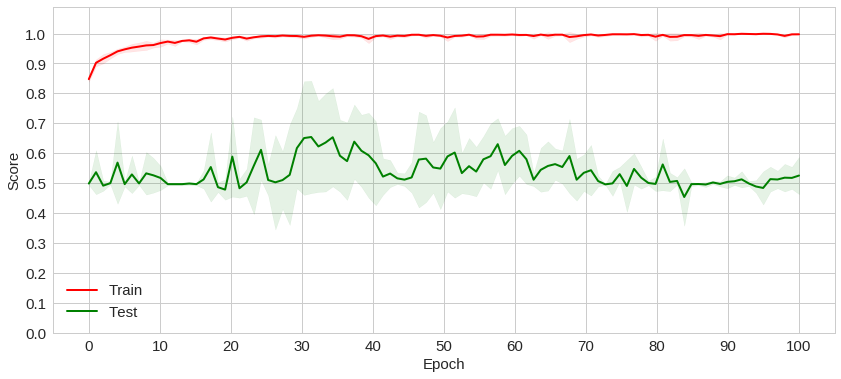

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

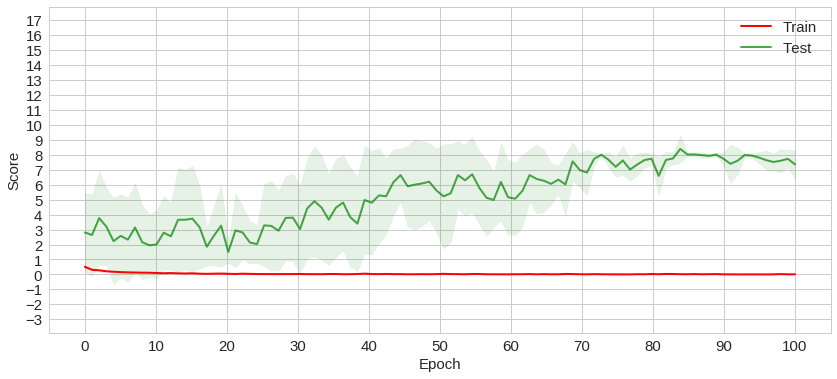

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

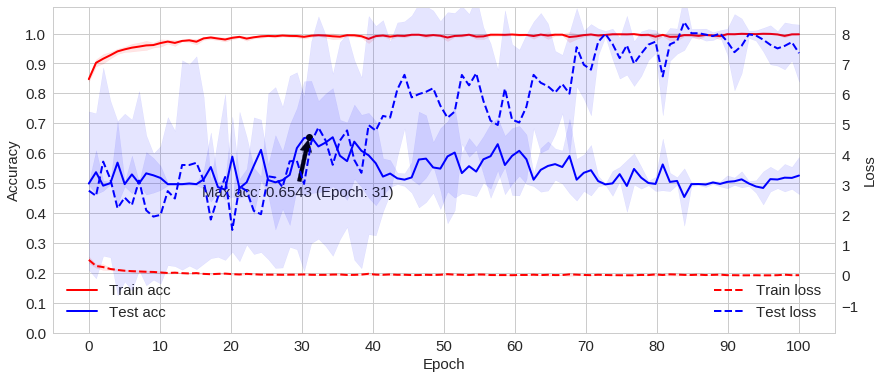

In [28]:
plot_mean(hist)